### 使用データ : https://www.kaggle.com/paresh2047/uci-semcom <br/>
#### **★分析目的**
対象データは半導体の製造プロセスにおける様々な測定ポイントから収集された信号/変数である。<br/>
しかし、観測されたデータには有用な情報以外に、無価値・ノイズ情報が混じっており全ての情報を収集するにはコストや時間面から見てもあまりよろしくない。<br/>
そこで本データ分析では半導体の製造プロセスにおける有用な情報(カラム情報)を選定し、生産コストの削減を目指すために原因推定を行う。

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
# You can go offline on demand by using
# cf.go_offline() 
# initiate notebook for offline plot
# init_notebook_mode(connected=False)         
# set some display options:
plt.rcParams['figure.dpi'] = 100
# colors = px.colors.qualitative.Prism
# pio.templates.default = "plotly_white"

from matplotlib import pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)
%matplotlib inline
#グラフのフォント変換
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('uci-secom.csv')
print(df.shape)
df.head()

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
#時系列順に並び変える
df = df.sort_values('Time')
df = df.reset_index(drop=True)
df.tail()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
1562,2008-12-10 02:59:00,2968.78,2451.53,2207.1000,1298.4309,1.0251,100.0,96.9478,0.1203,1.3985,...,185.3578,0.4972,0.0133,0.0036,2.6718,0.0167,0.0310,0.0084,185.3578,-1
1563,2008-12-10 03:21:00,2898.17,2547.65,NaN,NaN,NaN,NaN,NaN,0.0000,1.4425,...,NaN,0.5036,0.0161,0.0040,3.1902,0.0167,0.0310,0.0084,185.3578,-1
1564,2008-12-10 03:28:00,3045.87,2493.72,2168.5111,1171.6442,0.8752,100.0,101.6567,0.1235,1.5442,...,NaN,0.4998,0.0234,0.0050,4.6735,0.0167,0.0310,0.0084,185.3578,-1
1565,2008-12-10 08:19:00,2926.38,2383.76,2207.1000,1298.4309,1.0251,100.0,96.9478,0.1203,1.3561,...,128.6840,0.4986,0.0132,0.0038,2.6468,0.0172,0.0222,0.0072,128.6840,-1
1566,2008-12-10 18:47:00,3033.46,2424.39,2204.6667,1078.7860,0.9152,100.0,103.9611,0.1196,1.2898,...,58.7670,0.5008,0.0140,0.0037,2.7936,0.0246,0.0145,0.0038,58.7670,-1


In [4]:
#目的変数の1,0化
for i,value in enumerate(df['Pass/Fail']):
    if value == -1:
        df['Pass/Fail'][i] = 0
    else:
        df['Pass/Fail'][i] = 1

In [5]:
#欠損値の確認
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

df_na = null_values(df)
df_na_index = df_na.index

## 欠損の中身の傾向を把握する

説明変数292の散布図


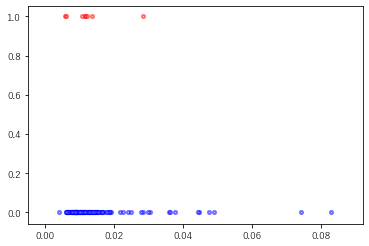

説明変数293の散布図


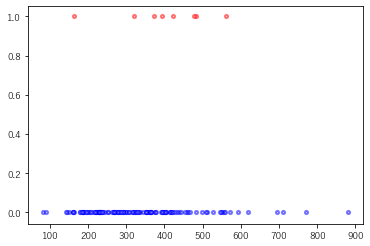

説明変数157の散布図


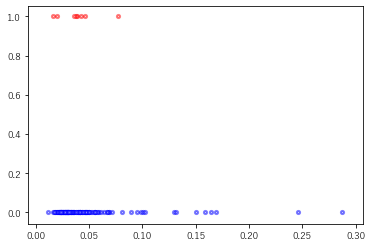

説明変数158の散布図


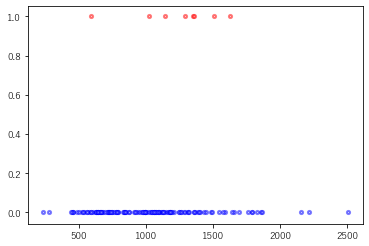

説明変数358の散布図


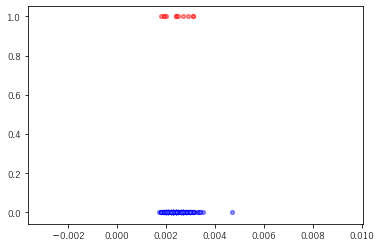

説明変数85の散布図


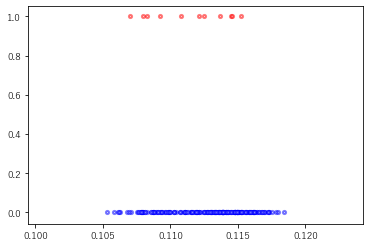

説明変数492の散布図


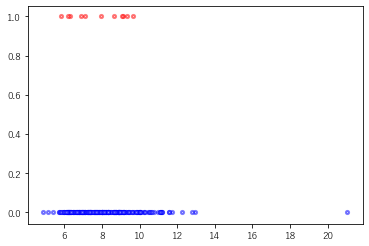

説明変数220の散布図


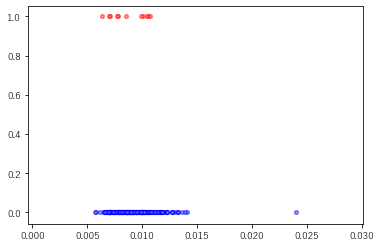

説明変数518の散布図


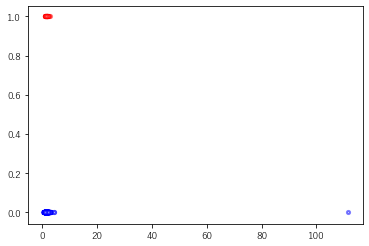

説明変数246の散布図


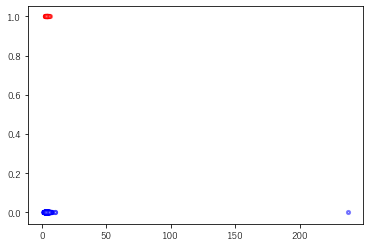

説明変数245の散布図


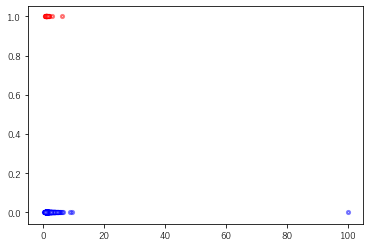

説明変数516の散布図


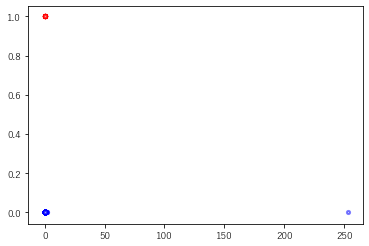

説明変数517の散布図


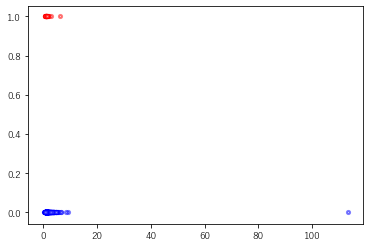

説明変数110の散布図


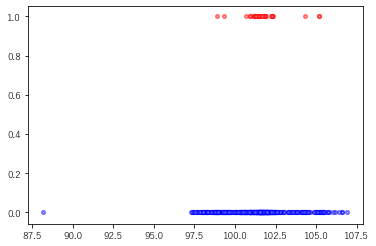

説明変数384の散布図


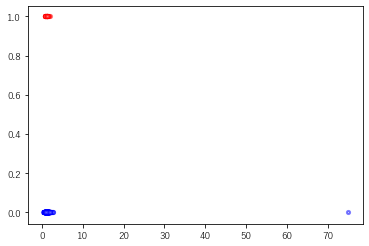

説明変数382の散布図


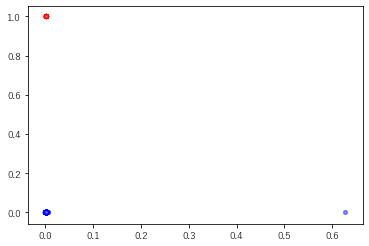

説明変数383の散布図


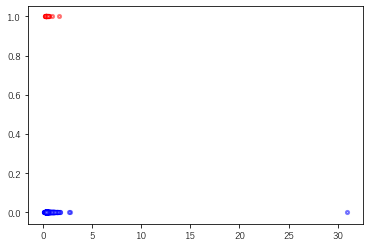

説明変数109の散布図


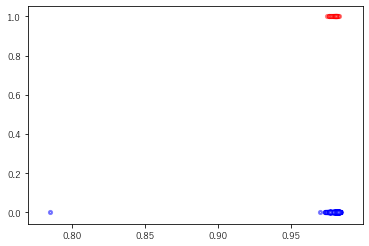

説明変数244の散布図


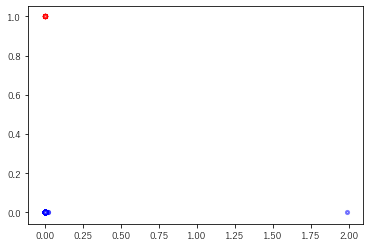

説明変数111の散布図


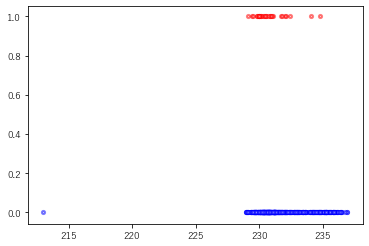

説明変数580の散布図


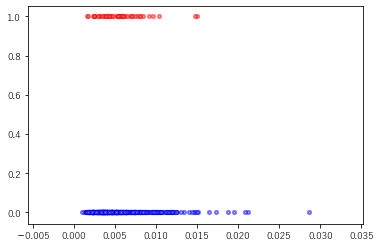

説明変数578の散布図


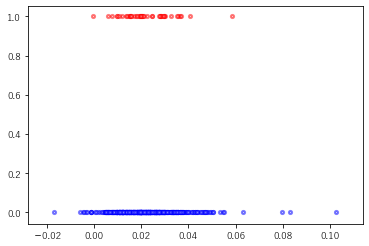

説明変数581の散布図


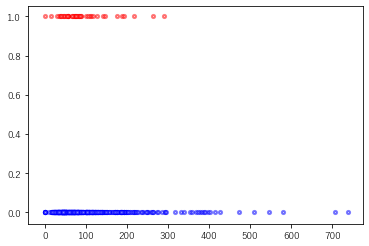

説明変数579の散布図


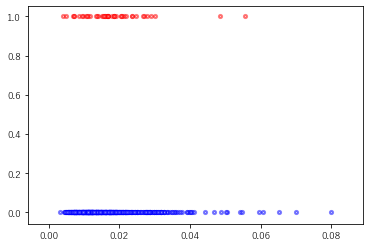

説明変数73の散布図


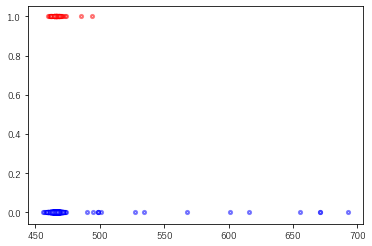

説明変数72の散布図


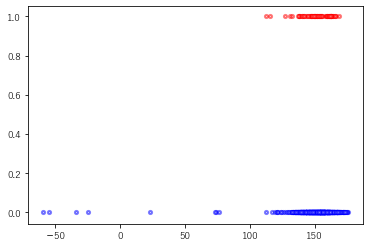

説明変数345の散布図


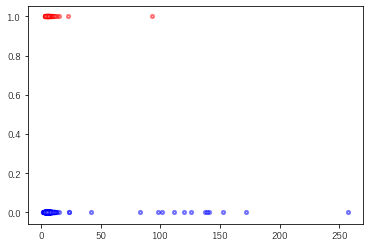

説明変数346の散布図


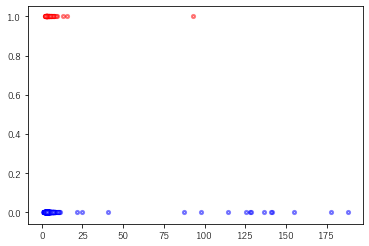

説明変数519の散布図


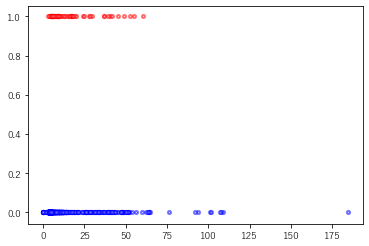

説明変数247の散布図


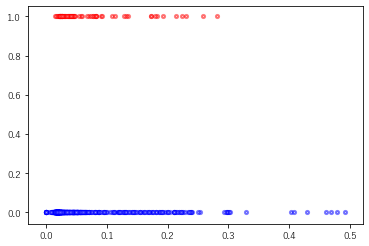

説明変数385の散布図


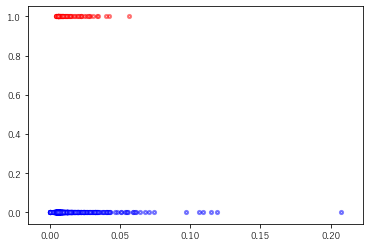

説明変数112の散布図


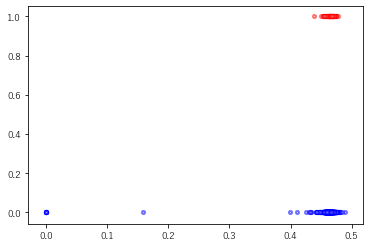

In [6]:
for i in df_na[0:32].index:
    print(f'説明変数{i}の散布図')
    x1 = df[df['Pass/Fail'] == 0][i]
    y1 = df[df['Pass/Fail'] == 0]['Pass/Fail']
    x2 = df[df['Pass/Fail'] == 1][i]
    y2 = df[df['Pass/Fail'] == 1]['Pass/Fail']
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # x1, y1を青色でプロット
    ax.scatter(x1, y1, s=10, alpha=0.5, linewidths=2, c='#aaaaFF', edgecolors='b')
    # x2, y2を赤色でプロット
    ax.scatter(x2, y2, s=10, alpha=0.5, linewidths=2, c='#FFaaaa', edgecolors='r')
    plt.show()

In [7]:
df_na[0:32].index

Index(['292', '293', '157', '158', '358', '85', '492', '220', '518', '246',
       '245', '516', '517', '110', '384', '382', '383', '109', '244', '111',
       '580', '578', '581', '579', '73', '72', '345', '346', '519', '247',
       '385', '112'],
      dtype='object')

In [8]:
#t検定,u検定の実施
features=df_na[0:32].index
depend_feature_t_certificate=[]
depend_feature_u_certificate=[]

for features in features:
    # 合格
    Pass = df[df['Pass/Fail'] == 0][features]
    # 不合格
    Fail = df[df['Pass/Fail'] == 1][features]

    #対応しない2郡間の差の検定
    A_var = np.var(Pass, ddof=1)  # Aの不偏分散
    B_var = np.var(Fail, ddof=1)  # Bの不偏分散
    A_df = len(Pass) - 1  # Aの自由度
    B_df = len(Fail) - 1  # Bの自由度
    
    try:
        f = A_var / B_var  # F比の値
        one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
        one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
        two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

#         print(f'説明変数「{features}」のt検定P値:{stats.ttest_ind(Pass, Fail)[1]}')
#         print(f'説明変数「{features}」のu検定P値:{stats.mannwhitneyu(Pass, Fail, alternative='two-sided')[1]}')
        
        if stats.ttest_ind(Pass, Fail)[1] < 0.05:
            depend_feature_t_certificate.append(features)
        elif stats.mannwhitneyu(Pass, Fail, alternative='two-sided')[1] < 0.05:
            depend_feature_u_certificate.append(features)
        else:
            continue
    except ZeroDivisionError:
        pass

In [9]:
depend_feature_t_certificate #(該当する有意差がない →独立ではない)

[]

In [11]:
#45%以上の欠損値の除外
df_na_columns = df_na.query('Percentage > 45').index #32個あり
df = df.drop(df_na_columns,axis=1)
print(df.shape)
df.head()

(1567, 560)


,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-01-08 02:02:00,3016.64,2492.80,2246.4889,1006.9548,1.0997,100.0,103.3222,0.1184,1.5068,...,21.2281,0.4984,0.0146,0.0040,2.9336,0.0296,0.0062,0.0018,20.8909,0
1,2008-01-08 05:52:00,2980.84,2628.76,2187.5222,1268.6598,1.4503,100.0,102.4622,0.1233,1.4672,...,16.3616,0.5010,0.0289,0.0061,5.7753,0.0297,0.0556,0.0150,187.3554,1
2,2008-01-08 10:20:00,2847.81,2461.38,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.4970,...,18.4846,0.4970,0.0093,0.0028,1.8722,0.0343,0.0115,0.0032,33.4515,0
3,2008-01-08 10:26:00,NaN,2544.52,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.4727,...,11.3646,0.5053,0.0121,0.0029,2.3957,0.0139,0.0187,0.0064,134.2014,0
4,2008-01-08 11:28:00,2975.64,2508.28,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.5079,...,21.8407,0.5001,0.0119,0.0033,2.3709,0.0139,0.0187,0.0064,134.2014,0


In [12]:
#percentageのrange設定
df_na['Percentage_range'] = df_na.astype({'Percentage': int})['Percentage']
for i in range(len(df_na['Percentage_range'])):
    for ran in range(10,110,10):
        if df_na['Percentage_range'][i] <= ran and  df_na['Percentage_range'][i] >= ran-10:
            df_na['Percentage_range'][i] = ran-10
        else:
            continue

In [13]:
df_na['Percentage_45over'] = '欠損'
for i in range(len(df_na['Percentage_range'])):
    if df_na['Percentage'][i] >= 45: 
        df_na['Percentage_45over'][i] = '45%以上欠損'
    else:
        df_na['Percentage_45over'][i] = '45%以下欠損'

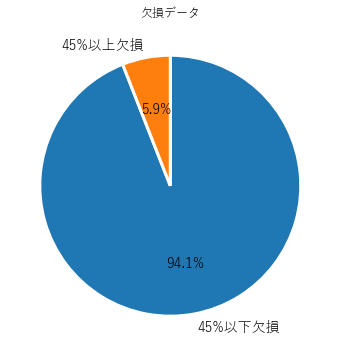

In [15]:
plt.figure(figsize=(6, 6), facecolor='w')
plt.pie(df_na['Percentage_45over'].value_counts(),
        labels=df_na["Percentage_45over"].value_counts().index,
        autopct='%.1f%%',
        startangle=90,
        counterclock=False,
        textprops={'fontsize':14},
        wedgeprops={'linewidth':3, 'edgecolor':'white'})
# plt.axis('equal')
plt.title('欠損データ')
plt.show()

In [16]:
# 目的変数と説明変数の相関を確認する(欠損値補完なし)
corr = df.corr()
corr['Pass/Fail'].sort_values(ascending=False)[1:15].to_frame() #相関の高い説明変数の抽出

,Pass/Fail
59,0.155796
103,0.151203
510,0.131593
348,0.130180
431,0.120851
434,0.112116
430,0.110067
435,0.109067
21,0.108488
436,0.106910


In [17]:
#とりあえず欠損値の補完をしてみる
df_median = df.fillna(df.median())#中央値での補完
df_0 = df.fillna(0)

In [18]:
# 目的変数と説明変数の相関を確認する(欠損値補完あり)
corr = df_median.corr()
corr['Pass/Fail'].sort_values(ascending=False)[1:15].to_frame() #相関の高い説明変数の抽出

,Pass/Fail
59,0.156008
103,0.151230
510,0.131662
348,0.130807
431,0.119936
434,0.111312
430,0.109115
21,0.108333
435,0.108260
436,0.106119


In [19]:
#月のデータ抽出
df["Month"] = pd.to_datetime(df["Time"]).dt.strftime("%Y-%m")
df["Hour"] = pd.to_datetime(df["Time"]).dt.strftime("%H")

In [20]:
df['Pass/Fail'].value_counts()

0    1463
1     104
Name: Pass/Fail, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text xticklabel objects>)

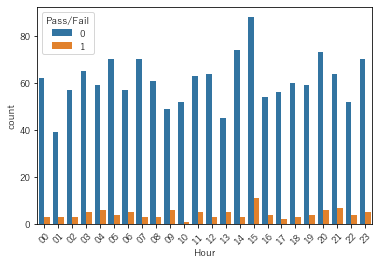

In [21]:
sns.countplot("Hour", data = df,hue='Pass/Fail')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

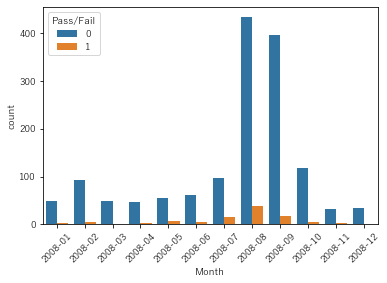

In [22]:
sns.countplot("Month", data = df,hue='Pass/Fail')
plt.xticks(rotation=45)

In [23]:
#グラフ詳細
print('月単位\n',df['Month'].value_counts())
print('不良品のカウント',df.groupby(['Month','Pass/Fail'])['Time'].count())

月単位
 2008-08    471
2008-09    413
2008-10    123
2008-07    114
2008-02     98
2008-06     67
2008-05     62
2008-01     51
2008-03     50
2008-04     49
2008-11     35
2008-12     34
Name: Month, dtype: int64
不良品のカウント Month    Pass/Fail
2008-01  0             48
         1              3
2008-02  0             93
         1              5
2008-03  0             49
         1              1
2008-04  0             46
         1              3
2008-05  0             55
         1              7
2008-06  0             61
         1              6
2008-07  0             98
         1             16
2008-08  0            433
         1             38
2008-09  0            396
         1             17
2008-10  0            117
         1              6
2008-11  0             33
         1              2
2008-12  0             34
Name: Time, dtype: int64


割合的にみると**7月**が1番不良品の数が多くなってしまっている